# Subreddit Classifier Project: Monty Python vs. Python Language
## Stage 3: Modeling


Now that my data has been cleansed and explored, and I have created new features using NLP techniques, I am ready to start building models to help identify whether a subreddit is appropriate for my marketing campaigns or not. 

I will start by creating a number of baseline models. The goal here is to try a broad range of classification models all using default parameters, and just the lemmatized title and self-text submission data from my subreddits. The goal is to correctly identify a subreddit as Python or MontyPython 90% or more of the time, so I can accurately target my marketing campaigns toward a data science audience.

Once I have a couple of baseline models that show promise, I will tune these to optimize for accuracy and bias/variance tradeoff. 

#### Notebook Guide:

- [Standard Imports](#imports) 
- [Starter Models](#base_model)
    - [Logistic Regression](#logreg_base)
    - [Multinomial Naive Bayes](#nb_base)
    - [KNN Classifier](#knn_base)
    - [Random Forest](#rf_base)
    - [Bagged Decision Tree](#bag_base)
    - [AdaBoost Classifier](#ada_base)
    - [Gradient Boosting](#gb_base)
    - [Extreme Gradient Boosting](#xgb_base)   
    - [Support Vector Classifier](#svc_base)
    - [Voting Classifier](#vote_base)
- [Tuned Final Models](#tuned_models)
    - [Logistic Regression](#logreg_final)
        - [Predicting on Text Data Only](#logreg_lem)
        - [Predicting on Text and Numeric](#logreg_fu)
    - [AdaBoost Classifier](#ada_final)
        - [Predicting on Text Data Only](#ada_lem)
        - [Predicting on Text and Numeric](#ada_fu)
    - [Multinomial Naive Bayes](#nb_final)
- [Model Evaluation](#eval)
    - [Model Performance Metrics](#model_metrics)
    - [Confusion Matrices](#conf_mtx)
    - [Evaluation Summary](#eval_sum)


<a id='imports'></a>
### Standard Imports

In [171]:
# Standard imports:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NLP imports:
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import FreqDist, pos_tag
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

# Estimator and Tranformer imports:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn import metrics

# Other useful imports:
import sys
import time

In [296]:
all_py = pd.read_csv('./data/all_py_2.csv')

In [725]:
all_py.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2998 entries, 0 to 2997
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   2998 non-null   object
 1   subreddit            2998 non-null   object
 2   title                2998 non-null   object
 3   selftext             1347 non-null   object
 4   title_selftext       2998 non-null   object
 5   subred               2998 non-null   int64 
 6   tokens               2998 non-null   object
 7   post_length          2998 non-null   int64 
 8   title_selftext_lem   2998 non-null   object
 9   title_selftext_stem  2998 non-null   object
dtypes: int64(2), object(8)
memory usage: 234.3+ KB


<a id='base_model'></a>
### Starter Models
As a first step, I am going to do two things:
1) Determine which of my text corpora are best to feed into a model: 
- title_selftext: original title & selftext columns from reddit with no alterations
- title_selftext_lem: lemmatized title & selftext
- title_selftext_stem: stemmed title & selftext 

2) Run a variety of classification models to understand their baseline performance with default parameters.

#### Best Corpus for Modeling:

In [321]:
# Setting up X and y variables:
X_orig = all_py['title_selftext'].tolist()
X_lem = all_py['title_selftext_lem'].tolist()
X_stem = all_py['title_selftext_stem'].tolist()
y = all_py['subred']

# Split data into training and testing sets:
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y, test_size=0.33, stratify = y, random_state = 42)
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y, test_size=0.33, stratify = y, random_state = 42)
X_train_stem, X_test_stem, y_train_stem, y_test_stem = train_test_split(X_stem, y, test_size=0.33, stratify = y, random_state = 42)

# Instantiate a CountVectorizer:
cvec = CountVectorizer()
cv_lem = CountVectorizer()
cv_stem = CountVectorizer()

# Fit the training corpus:
cvec.fit(X_train_orig, y_train_orig)
cv_lem.fit(X_train_lem, y_train_lem)
cv_stem.fit(X_train_stem, y_train_stem)

# Transform the training & testing corpora:
Z_train_orig = cvec.transform(X_train_orig)
Z_test_orig = cvec.transform(X_test_orig)

Z_train_lem = cv_lem.transform(X_train_lem)
Z_test_lem = cv_lem.transform(X_test_lem)

Z_train_stem = cv_stem.transform(X_train_stem)
Z_test_stem = cv_stem.transform(X_test_stem)

In [322]:
train_test = [(Z_train_orig, y_train_orig, Z_test_orig, y_test_orig, 'Original Corpus'), 
              (Z_train_lem, y_train_lem, Z_test_lem, y_test_lem, 'Lemmatized Corpus'), 
              (Z_train_stem, y_train_stem, Z_test_stem, y_test_stem, 'Stemmed Corpus')]

print('LOGISTIC REGRESSION SCORES')
for Z, y, Zt, yt, corp in train_test:
    logreg = LogisticRegression()
    logreg.fit(Z, y)

    print(corp + ':')
    print(f'Training: {metrics.f1_score(y, logreg.predict(Z)).round(4)}')
    print(f'Testing: {metrics.f1_score(yt, logreg.predict(Zt)).round(4)}')
    print()
    
print('NAIVE BAYES SCORES')
for Z, y, Zt, yt, corp in train_test:
    mnb = MultinomialNB()
    mnb.fit(Z, y)
    print(corp + ':')
    print(f'Training: {metrics.f1_score(y, mnb.predict(Z)).round(4)}')
    print(f'Testing: {metrics.f1_score(yt, mnb.predict(Zt)).round(4)}')
    print()
    
print('ADABOOST SCORES')
for Z, y, Zt, yt, corp in train_test:
    ada = AdaBoostClassifier()
    ada.fit(Z, y)
    print(corp + ':')
    print(f'Training: {metrics.f1_score(y, ada.predict(Z)).round(4)}')
    print(f'Testing: {metrics.f1_score(yt, ada.predict(Zt)).round(4)}')
    print()
    
print('SUPPORT VECTOR SCORES')
for Z, y, Zt, yt, corp in train_test:
    svc = LinearSVC()
    svc.fit(Z, y)
    print(corp + ':')
    print(f'Training: {metrics.f1_score(y, svc.predict(Z)).round(4)}')
    print(f'Testing: {metrics.f1_score(yt, svc.predict(Zt)).round(4)}')
    print()

LOGISTIC REGRESSION SCORES
Original Corpus:
Training: 0.9866
Testing: 0.903

Lemmatized Corpus:
Training: 0.9861
Testing: 0.9074

Stemmed Corpus:
Training: 0.9866
Testing: 0.9156

NAIVE BAYES SCORES
Original Corpus:
Training: 0.9688
Testing: 0.9146

Lemmatized Corpus:
Training: 0.9674
Testing: 0.9184

Stemmed Corpus:
Training: 0.9655
Testing: 0.9129

ADABOOST SCORES
Original Corpus:
Training: 0.9275
Testing: 0.8819

Lemmatized Corpus:
Training: 0.9267
Testing: 0.8774

Stemmed Corpus:
Training: 0.9288
Testing: 0.8905

SUPPORT VECTOR SCORES
Original Corpus:
Training: 0.9975
Testing: 0.9158

Lemmatized Corpus:
Training: 0.9975
Testing: 0.9223

Stemmed Corpus:
Training: 0.9975
Testing: 0.9218



**With the exception of Naive Bayes, the Stemmed Corpus did the best at generating strong accuracy in the training set, and generaled to the test data better than other corpora. Moving forward, I will use the Stemmed corpus for modeling.**

#### Starter Models

In [573]:
# Setting Stemmed training and testing data as model variables:
Z_train = Z_train_stem
Z_test = Z_test_stem
y_train = y_train_stem
y_test = y_test_stem

<a id='logreg_base'></a>
**Logistic Regression**

In [574]:
log_base = LogisticRegression()
log_base.fit(Z_train, y_train)
print(f'Training: {metrics.f1_score(y_train, log_base.predict(Z_train)).round(4)}')
print(f'Testing: {metrics.f1_score(y_test, log_base.predict(Z_test)).round(4)}')

Training: 0.9866
Testing: 0.9156


<a id='nb_base'></a>
**Multinomial Naive Bayes**

In [575]:
nb_base = MultinomialNB()
nb_base.fit(Z_train, y_train)
print(f'Training: {metrics.f1_score(y_train, nb_base.predict(Z_train)).round(4)}')
print(f'Testing: {metrics.f1_score(y_test, nb_base.predict(Z_test)).round(4)}')

Training: 0.9655
Testing: 0.9129


<a id='knn_base'></a>
**KNN**

In [576]:
knn_base = KNeighborsClassifier()
knn_base.fit(Z_train, y_train)
print(f'Training: {metrics.f1_score(y_train, knn_base.predict(Z_train)).round(4)}')
print(f'Testing: {metrics.f1_score(y_test, knn_base.predict(Z_test)).round(4)}')

Training: 0.8751
Testing: 0.8005


<a id='rf_base'></a>
**Random Forest**

In [577]:
rf_base = RandomForestClassifier(random_state=42)
rf_base.fit(Z_train, y_train)
print(f'Training: {metrics.f1_score(y_train, rf_base.predict(Z_train)).round(4)}')
print(f'Testing: {metrics.f1_score(y_test, rf_base.predict(Z_test)).round(4)}')

Training: 0.998
Testing: 0.9201


<a id='bag_base'></a>
**Bagged Decision Tree**

In [578]:
bag_base = BaggingClassifier(random_state=42)
bag_base.fit(Z_train, y_train)
print(f'Training: {metrics.f1_score(y_train, bag_base.predict(Z_train)).round(4)}')
print(f'Testing: {metrics.f1_score(y_test, bag_base.predict(Z_test)).round(4)}')

Training: 0.99
Testing: 0.8914


<a id='ada_base'></a>
**AdaBoost Classifier**

In [579]:
ada_base = AdaBoostClassifier(random_state=42)
ada_base.fit(Z_train, y_train)
print(f'Training: {metrics.f1_score(y_train, ada_base.predict(Z_train)).round(4)}')
print(f'Testing: {metrics.f1_score(y_test, ada_base.predict(Z_test)).round(4)}')

Training: 0.9288
Testing: 0.8905


<a id='gb_base'></a>
**Gradient Boosting**

In [580]:
gb_base = GradientBoostingClassifier(random_state=42)
gb_base.fit(Z_train, y_train)
print(f'Training: {metrics.f1_score(y_train, gb_base.predict(Z_train)).round(4)}')
print(f'Testing: {metrics.f1_score(y_test, gb_base.predict(Z_test)).round(4)}')

Training: 0.9217
Testing: 0.8758


<a id='xgb_base'></a>
**XGB Boosting Classifier**

In [581]:
xgb_base = XGBClassifier(use_label_encoder=False, eval_metric='error', random_state=42)
xgb_base.fit(Z_train, y_train)
print(f'Training: {metrics.f1_score(y_train, xgb_base.predict(Z_train)).round(4)}')
print(f'Testing: {metrics.f1_score(y_test, xgb_base.predict(Z_test)).round(4)}')

Training: 0.9719
Testing: 0.9042


<a id='svc_base'></a>
**Support Vector Classifier**

In [582]:
svc_base = SVC(random_state=42)
svc_base.fit(Z_train, y_train)
print(f'Training: {metrics.f1_score(y_train, svc_base.predict(Z_train)).round(4)}')
print(f'Testing: {metrics.f1_score(y_test, svc_base.predict(Z_test)).round(4)}')

Training: 0.922
Testing: 0.8726


<a id='vote_base'></a>
**Voting Classifier**

In [583]:
vote_base = VotingClassifier([
    ('ada', AdaBoostClassifier(random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42)),
#    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='error')),    
#    ('knn', KNeighborsClassif`ier()),
    ('svc', SVC(random_state=42)),
    ('nb', MultinomialNB())
])
vote_base.fit(Z_train, y_train)
print(f'Training: {metrics.f1_score(y_train, vote_base.predict(Z_train)).round(4)}')
print(f'Testing: {metrics.f1_score(y_test, ada_base.predict(Z_test)).round(4)}')

Training: 0.932
Testing: 0.8905


In [665]:
# model_scores = pd.DataFrame(columns = ['Model', 'Testing F1', 'Training F1'])

models = [log_base, nb_base, knn_base, rf_base, ada_base, bag_base, gb_base, xgb_base, svc_base, vote_base]

model = 'Baseline Model'
train_score = .5101 # metrics.f1_score(y_train, log_base.predict(Z_train)).round(4)
test_score = .4993 # metrics.f1_score(y_test, log_base.predict(Z_test)).round(4)

model_scores = model_scores.append({'Model' : model,
                     'Testing F1' : test_score, 
                     'Training F1' : train_score}, 
                 ignore_index = True)

# model_scores2 = []
# for m in models:
#     train_preds = m.predict(Z_train)
#     test_preds = m.predict(Z_test)
#     train_score = metrics.f1_score(y_train, train_preds).round(4)
#     test_score = metrics.f1_score(y_test, test_preds).round(4)
#     model_scores2.append({'Model' : m, 'Training F1' : train_score, 'Testing F1' : test_score}) 


In [666]:
model_scores

,Model,Testing F1,Training F1
0,Voting Classifier,0.8906,0.9320
1,Support Vector Classifier,0.8726,0.9220
2,X Gradient Boosting,0.9042,0.9719
3,Gradient Boosting,0.8758,0.9217
4,AdaBoost Classifier,0.8905,0.9288
5,Bagging Classifier,0.8914,0.9900
6,Random Forest,0.9201,0.9980
7,KNN Classifier,0.8005,0.8751
8,Multinomial Naive Bayes,0.9129,0.9655
9,Logistic Regression,0.9156,0.9866


In [667]:
model_scores.set_index('Model', inplace=True)

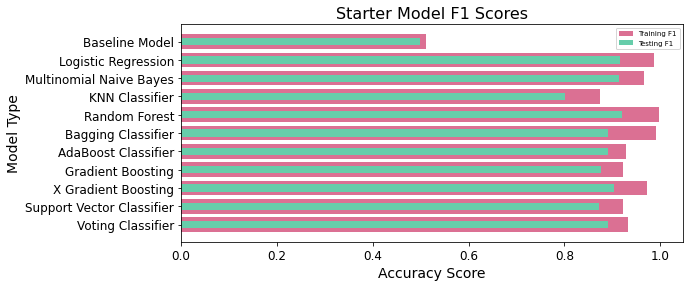

In [718]:
# Create plot showing traing and testing F1 scores for all the starter models using Stemmed corpus as X variable:

# mod_scores = model_scores.plot(kind='barh', figsize=(10,6), legend='reverse', colormap='Paired', fontsize=12)
# plt.title("Starter Model F1 Scores")
# plt.xlabel('Accuracy Score');
# plt.show();

mod_scores2 = plt.figure(figsize=(9, 4)) 
plt.xlabel('Accuracy Score', fontsize=14)
plt.ylabel('Model Type', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Starter Model F1 Scores', fontsize=16)
train = plt.barh(model_scores.index, model_scores['Training F1'], height=.8, color='palevioletred')
test = plt.barh(model_scores.index, model_scores['Testing F1'], height=.4, color='mediumaquamarine')
plt.legend((train, test), ('Training F1', 'Testing F1'), fontsize=7)
plt.show();

In [719]:
mod_scores2.savefig("./images/startmodel_scores.png", bbox_inches='tight')

<a id='tuned_models'></a>
### Tuned Final Models

Despite high variance for some models, many are generalizing to new data with 90% or higher accuracy which accomplishes my goal. I am going to focus on honing two models, one that will allow for better evaluation and one that optimizes accuracy with bias/variance tradeoff:
* Logistic Regression = accuacy + explanability
* Naive Bayes = accuracy + lower varaince


<a id='logreg_final'></a>
#### Logistic Regression Model

<a id='logreg_lem'></a>
**Predicting on Text Data Only**\
As a starting point, I will model on my stemmed text corpus only. In the baseline models, the lemmatized corpus performed sligthly better than the non-lemmatized one for some models.

In [722]:
# Create X and y variables:
X_stem = all_py['title_selftext_stem'].tolist()
y = all_py['subred']

# Split data into training and testing sets:
Z_train, Z_test, y_train, y_test = train_test_split(X_stem, y, test_size=0.33, stratify = y, random_state = 42)


In [383]:
# Creating custom list of stopwords that include all 'english' plus my own added:

from sklearn.feature_extraction import text 
my_added_words = ['python', 'https', 'removed', 'http', 'amp']
my_stop_words = text.ENGLISH_STOP_WORDS.union(my_added_words)

In [384]:
# Set up a pipeline with CountVectorizer and TfidfTransformer as our transformers, and Logistic Regression as our estimator:
# Credit for the idea of pairing TfidfTransformer with CountVectorizer is from this article: 
# https://towardsdatascience.com/sentiment-analysis-of-tweets-using-multinomial-naive-bayes-1009ed24276b

lr_pipe = Pipeline([('cvec', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('logreg', LogisticRegression(solver = 'liblinear', max_iter=10_000))
                ])

In [385]:
# Set pipe parameters for GridSearch:
lr_pipe_params = {
    'cvec__max_features': [3750, 4500, 5500],
    'cvec__min_df': [1,2],
    'cvec__max_df': [.75, .8], 
    'cvec__ngram_range' : [(1,1), (1,2), (1,3)],
    'cvec__stop_words' : [None, 'english', my_stop_words],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'logreg__penalty':['l1', 'l2'],
}
TfidfTransformer()

In [386]:
# Set up the GridSearch:
gs_lr_lem = GridSearchCV(lr_pipe,
                      lr_pipe_params,
                      cv = 5,
                      verbose=1,
                      n_jobs=1)

In [387]:
# Fit GridSearch to training data:
gs_lr_lem.fit(Z_train, y_train)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/heatherjohansen/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heatherjohansen/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heatherjohansen/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/heatherjohansen/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to conv

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('logreg',
                                        LogisticRegression(max_iter=10000,
                                                           solver='liblinear'))]),
             n_jobs=1,
             param_grid={'cvec__max_df': [0.75, 0.8],
                         'cvec__max_features': [3750, 4500, 5500],
                         'cvec__min_df': [1, 2],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'cvec__stop_words': [None, 'english',
                                              fr...'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
       

In [544]:
lr_stem_train = metrics.f1_score(y_train, gs_lr_lem.predict(Z_train)).round(4)
lr_stem_test = metrics.f1_score(y_test, gs_lr_lem.predict(Z_test)).round(4)
print('Logistic Regression on Stemmed Text Data:')
print(f'Training score: {lr_stem_train}')
print(f'Testing score: {lr_stem_test}')

Logistic Regression on Stemmed Text Data:
Training score: 0.9719
Testing score: 0.9254


In [389]:
gs_lr_lem.best_params_

{'cvec__max_df': 0.75,
 'cvec__max_features': 4500,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english',
 'logreg__penalty': 'l2',
 'tfidf__norm': 'l2',
 'tfidf__use_idf': True}

**Results:** Tuning hyperparameters has narrowed the variance sligthly compared to my starter LogisticRegression model, and improved accuracy of test set predictions. 

| Model      | Training Accuracy | Testing Accuracy |
| ----------- | ----------- | ----------- |
| Logistic Regression Starter  | 98.7%       |  91.6%  |
| Logistic Regression Tuned   | 97.2%        |  92.6%   |

###### <a id='logreg_fu'></a>
\
\
**Predicting on Text and Numeric Features**\
Now that I have improved on my starter Logistic Regression model by reducing variance, I will add an additional feature - post_length - to see if that helps improve the predictive power of my model.

In [390]:
# Use FunctionTransformer to separate the text and numeric features that will comprise my X variable:

get_text_data = FunctionTransformer(lambda x: x['title_selftext_stem'], validate = False)
get_numeric_data = FunctionTransformer(lambda x: x[['post_length']], validate = False)

In [392]:
# Create X and y variables and perform train_test_split:
# I will use the same training and testing sets for all models using text and numeric X variables, in order to ensure the models are comparable. 

X_fu = all_py[['title_selftext_stem', 'post_length']]
y_fu = all_py['subred']

np.random.seed(42)

X_train_fu, X_test_fu, y_train_fu, y_test_fu = train_test_split(X_fu, y_fu, test_size=0.33, stratify = y, random_state=42)

In [401]:
lrfu_pipe = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data)
            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('cvec', CountVectorizer()),
                ('tfidf', TfidfTransformer())
            ]))
    ])),
     ('logreg', LogisticRegression(solver = 'liblinear', max_iter=10_000))
])

lrfu_pipe_params = {
    'features__text_features__cvec__max_features': [4500, 3750, 3000],
    'features__text_features__cvec__min_df': [1,2],
    'features__text_features__cvec__max_df': [.7, .75, .8],
    'features__text_features__cvec__ngram_range' : [(1,1), (1,2)],
    'features__text_features__cvec__stop_words' : [None, 'english'],
    'features__text_features__tfidf__use_idf': (True, False),
    'features__text_features__tfidf__norm': ('l1', 'l2'),
    'logreg__penalty': ['l1', 'l2']
}

lr_fu_gs = GridSearchCV(lrfu_pipe, lrfu_pipe_params, cv=5, verbose=1)

lr_fu_gs.fit(X_train_fu, y_train_fu)
lr_fu_gs.score(X_train_fu, y_train_fu)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2880 out of 2880 | elapsed:  4.0min finished


0.9621513944223108

In [402]:
lrfu_train = lr_fu_gs.score(X_train_fu, y_train_fu)
lrfu_test = lr_fu_gs.score(X_test_fu, y_test_fu)
print('Logistic Regression with Text & Numeric Features:')
print(f'Training score: {lrfu_train.round(3)}')
print(f'Testing score: {lrfu_test.round(3)}')

Logistic Regression with Text & Numeric Features:
Training score: 0.962
Testing score: 0.92


In [403]:
lr_fu_gs.best_params_

{'features__text_features__cvec__max_df': 0.7,
 'features__text_features__cvec__max_features': 3750,
 'features__text_features__cvec__min_df': 1,
 'features__text_features__cvec__ngram_range': (1, 1),
 'features__text_features__cvec__stop_words': None,
 'features__text_features__tfidf__norm': 'l2',
 'features__text_features__tfidf__use_idf': True,
 'logreg__penalty': 'l2'}

**Results:** The addition of post length did not improve accuracy of the model. This is likely because the Bag of Words approach already takes into account the number of words in each "bag" so adding this feature ended up being redundant. 


| Model      | Training Accuracy | Testing Accuracy |
| ----------- | ----------- | ----------- |
| Logistic Regression Starter  | 98.7%       |  91.6%  |
| Logistic Regression Tuned   | 97.2%        |  92.6%   |
| Logistic Regression Text & Numeric   | 96.2%        |  92.0%   |

<a id='nb_final'></a> 

#### Naive Bayes

<a id='nb_lem'></a>
**Predicting on Text Data Only**\
Because adding in the post_length field was not beneficial to the Logistic Regression Model, I will only tune the Naive Bayes model fit to stemmed text data. 

In [720]:
# Set up a pipeline with CountVectorizer and TfidfTransformer as our transformers, 
# and Mulitnomial Naive Bayes as our estimator:
# I will use the same Z_train and y_train that were built for the Logistic Regression, text only, model above. 

pipe = Pipeline([('cvec', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('nb', MultinomialNB())
                ])

In [407]:
# Set pipe parameters for GridSearch:
pipe_params = {
    'cvec__max_features': [3500, 3750, 4250, 4500],
    'cvec__min_df': [1,2,3],
    'cvec__max_df': [.75, .85, .95], 
    'cvec__ngram_range' : [(1,1), (1,2)],
    'cvec__stop_words' : [None, 'english'],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'nb__alpha': [1, 1e-1, 1e-2]
}

In [408]:
# Set up the GridSearch:
gs_cvec_nb = GridSearchCV(pipe,
                      pipe_params,
                      cv = 5,
                      verbose=1,
                      n_jobs=2)

In [409]:
# Fit GridSearch to training data:
gs_cvec_nb.fit(Z_train, y_train)

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 104 tasks      | elapsed:    5.7s
[Parallel(n_jobs=2)]: Done 704 tasks      | elapsed:   31.8s
[Parallel(n_jobs=2)]: Done 1704 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done 3104 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done 4904 tasks      | elapsed:  3.6min
[Parallel(n_jobs=2)]: Done 7104 tasks      | elapsed:  5.1min
[Parallel(n_jobs=2)]: Done 8640 out of 8640 | elapsed:  6.1min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=2,
             param_grid={'cvec__max_df': [0.75, 0.85, 0.95],
                         'cvec__max_features': [3500, 3750, 4250, 4500],
                         'cvec__min_df': [1, 2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [None, 'english'],
                         'nb__alpha': [1, 0.1, 0.01],
                         'tfidf__norm': ('l1', 'l2'),
                         'tfidf__use_idf': (True, False)},
             verbose=1)

In [421]:
gs_cvec_nb.best_score_

0.9352526643590032

In [422]:
gs_cvec_nb.best_params_

{'cvec__max_df': 0.75,
 'cvec__max_features': 4500,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None,
 'nb__alpha': 0.01,
 'tfidf__norm': 'l2',
 'tfidf__use_idf': False}

<a id='eval'></a>
### Model Evaluation

<a id='model_metrics'></a>
#### Model Performance Scores:

In [723]:
# Based on the F1 scores on training and testing sets, my model is still overfit, but less so than with the . 
# However, it still meets the goal of 90% + accuracy on testing predictions.

nb_stem_train = metrics.f1_score(y_train, gs_cvec_nb.predict(Z_train)).round(4)
nb_stem_test = metrics.f1_score(y_test, gs_cvec_nb.predict(Z_test)).round(4)
print('Naive Bayes Scores:')
print(f'Training F1 score: {nb_stem_train}')
print(f'Testing F1 score: {nb_stem_test}')

# Get predictions
preds = gs_cvec_nb.predict(Z_test)

# Get confusion matrix values
tn_nb, fp_nb, fn_nb, tp_nb = confusion_matrix(y_test, preds).ravel()

# Calculate the Classification Model metrics:
accuracy_nb = (tp_nb + tn_nb) / (tp_nb + tn_nb + fp_nb + fn_nb)
print(f'Accuracy: {accuracy_nb.round(4)}')

precision_nb = tp_nb / (tp_nb + fp_nb)
print(f'Precision: {precision_nb.round(4)}')

recall_nb = tp_nb / (tp_nb + fn_nb)
print(f'Recall: {recall_nb.round(4)}')



Naive Bayes Scores:
Training F1 score: 0.9771
Testing F1 score: 0.9243
Accuracy: 0.9202
Precision: 0.8796
Recall: 0.9737


In [724]:
# Based on the F1 scores on training and testing sets, my model is a little overfit. 
# However, it still meets the goal of 90% + accuracy on testing predictions.

lr_stem_train = metrics.f1_score(y_train, gs_lr_lem.predict(Z_train)).round(4)
lr_stem_test = metrics.f1_score(y_test, gs_lr_lem.predict(Z_test)).round(4)
print('Logistic Regression Scores:')
print(f'Training F1 score: {lr_stem_train}')
print(f'Testing F1 score: {lr_stem_test}')

# Get predictions for Logistic Regression:
preds_lr = gs_lr_lem.predict(Z_test)

# Get confusion matrix values
tn_logreg, fp_logreg, fn_logreg, tp_logreg = confusion_matrix(y_test, preds_lr).ravel()

# Calculate the Classification Model metrics:
accuracy_lr = (tp_logreg + tn_logreg) / (tp_logreg + tn_logreg + fp_logreg + fn_logreg)
print(f'Accuracy: {accuracy_lr.round(4)}')

precision_logreg = tp_logreg / (tp_logreg + fp_logreg)
print(f'Precision: {precision_logreg.round(4)}')

recall_logreg = tp_logreg / (tp_logreg + fn_logreg)
print(f'Recall: {recall_logreg.round(4)}')

Logistic Regression Scores:
Training F1 score: 0.9719
Testing F1 score: 0.9254
Accuracy: 0.9263
Precision: 0.936
Recall: 0.9152


<a id='conf_mtx'></a>
#### Confusion Matrices

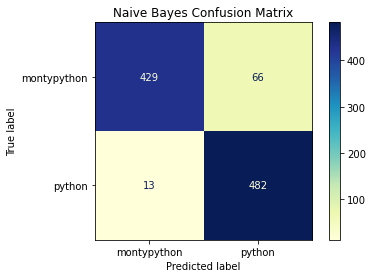

In [528]:
nb_confmx = plot_confusion_matrix(gs_cvec_nb, Z_test, y_test, display_labels=['montypython', 'python'], cmap="YlGnBu")
plt.title('Naive Bayes Confusion Matrix');

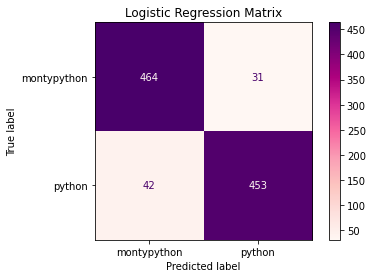

In [529]:
lr_confmx = plot_confusion_matrix(gs_lr_lem, Z_test, y_test, display_labels=['montypython', 'python'], cmap="RdPu")
plt.title('Logistic Regression Matrix');

<a id='eval_sum'></a>
#### Evaluation Summary:
Both Logistic Regression and Naïve Bayes models are performing strongly based on key metrics:
* Accuracy on testing data > 90%
* F1 Scores for testing data ~ 92.5%

Where the models differ is in Precision and Recall:
* Logistic Regression has higher precision and lower recall, meaning in the equation for the harmonized F1 score, it reduces False Positives but allows more False Negatives. 
* Naive Bayes has lower precision and higher recall, so it allows more False Positives than Logistic Regression, but fewer False Negatives. In addition, these scores have a wider variance that the Logistic Regression scores, despite similar blended F1 scores for both models. 

Because False Positives will become the target audience for one-to-one targeting, marketing objectives will drive final model selection:
* Naïve Bayes = Increase reach, lower ROAS
* Logistic Regression = Reduced reach, higher ROAS

<a id='conclusion'></a>